In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


# Insect vocalizations
Source:
- https://link.springer.com/chapter/10.1007/978-3-319-26561-2_42
- https://link.springer.com/chapter/10.1007/978-1-4614-3501-3_24

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import librosa

In [5]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn.visualization.spectrogram import visualize_spec, plot_spec
from avgn.utils.hparams import HParams
from avgn.signalprocessing.filtering import butter_bandpass_filter
from avgn.signalprocessing import spectrogramming as sg
import wave

### data locations

In [6]:
DSLOC = Path('/mnt/cube/Datasets/insectORIG')

In [7]:
DSLOC

PosixPath('/mnt/cube/Datasets/insectORIG')

### load wavs

In [8]:
wavs = list(DSLOC.glob('*.wav'))
len(wavs), wavs[:3]

(381,
 [PosixPath('/mnt/cube/Datasets/insectORIG/CC_139CS.wav'),
  PosixPath('/mnt/cube/Datasets/insectORIG/KA_himegisu.wav'),
  PosixPath('/mnt/cube/Datasets/insectORIG/CR_479scdg.wav')])

In [9]:
wav_df = pd.DataFrame(
    [[i, i.stem.split("_")[0], i.stem.split("_")[1]] for i in wavs],
    columns=["wavloc", "species_group", "species"],
)

In [10]:
wav_df[:3]

wavloc species_group   species
0     /mnt/cube/Datasets/insectORIG/CC_139CS.wav            CC     139CS
1  /mnt/cube/Datasets/insectORIG/KA_himegisu.wav            KA  himegisu
2   /mnt/cube/Datasets/insectORIG/CR_479scdg.wav            CR   479scdg

In [29]:
wav_df.species_group.unique()

array(['CC', 'KA', 'CR', 'MQ', 'WA', 'MI', 'BE', 'FF', 'BT'], dtype=object)

In [11]:
rate = 44100

In [19]:
win_length_ms = 1
hop_length_ms = .1
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4800,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-40,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=1000,
    mel_upper_edge_hertz=rate/2,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

44.1
4.41


### Show spectrogram

In [22]:
len(wav_df)

381

['CC', '299CS']

CR_479scdg
5.085170068027211


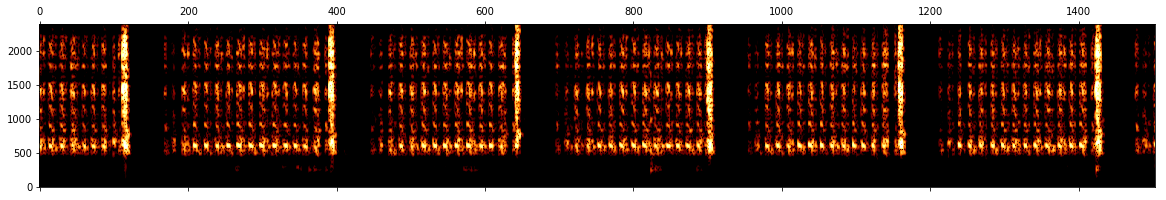

CR_468ssdw
5.137596371882086


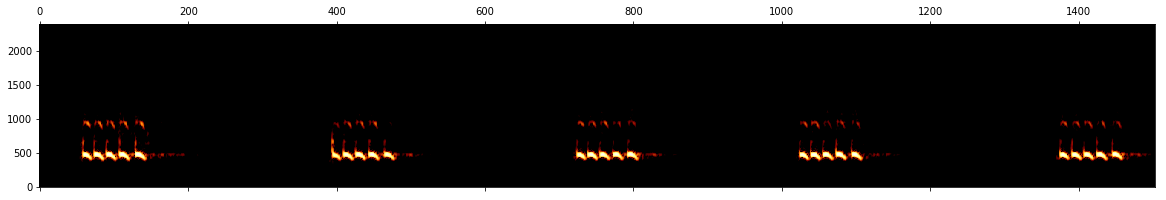

CR_450ss
5.702766439909297


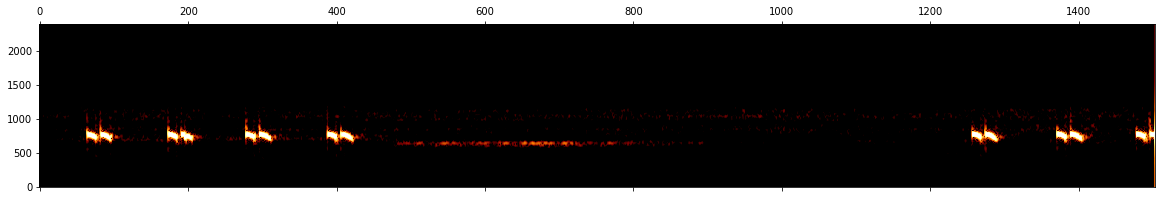

CR_618ss
5.894739229024943


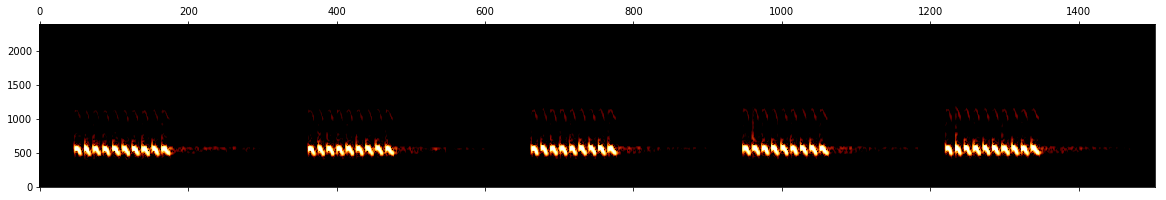

CR_614ss
6.010022675736962


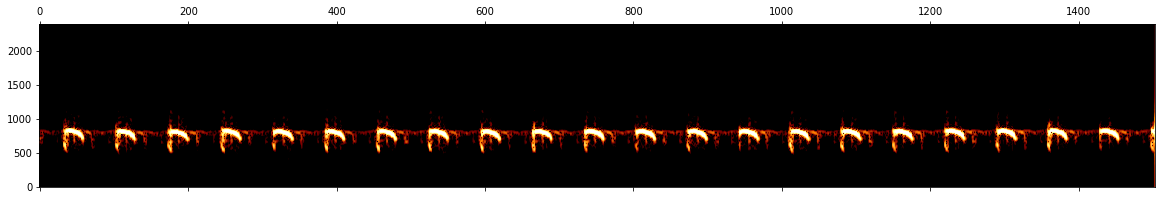

CR_686ss
5.692380952380953


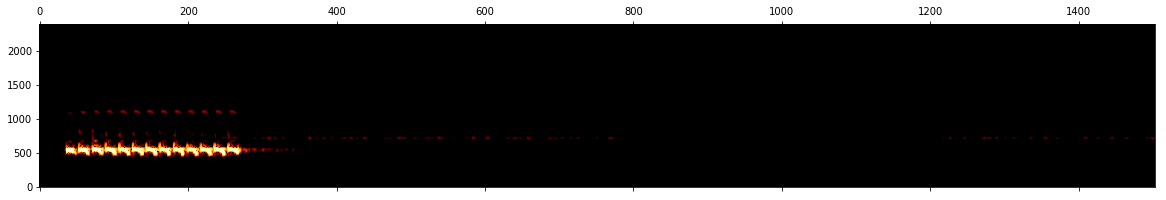

CR_fall_field_cricket
5.926303854875283


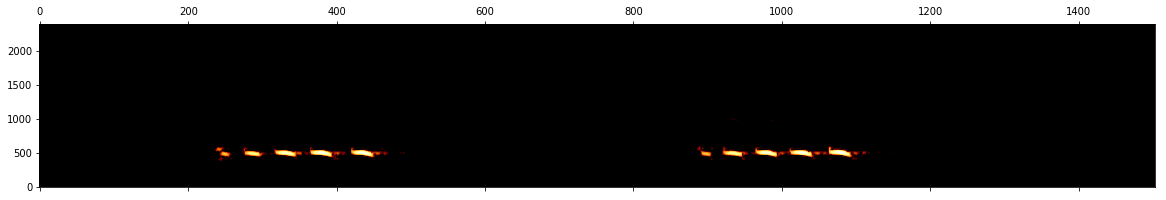

CR_583ss
6.071655328798186


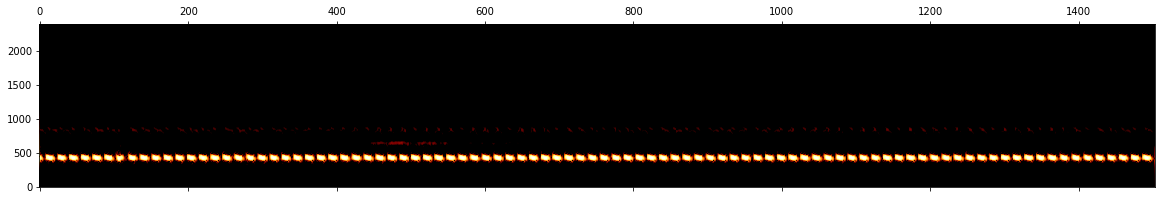

CR_kumasuzumushi
28.92045351473923


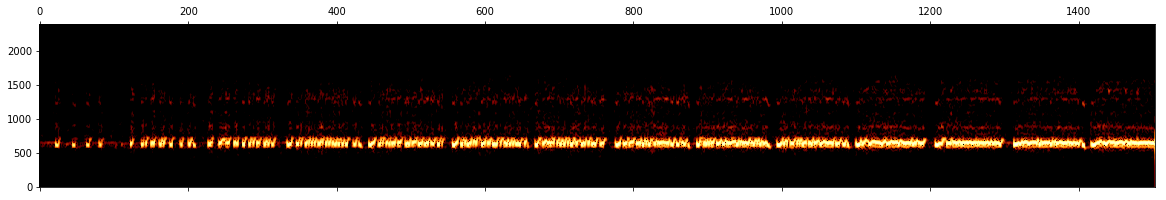

CR_446ss
5.208707482993197


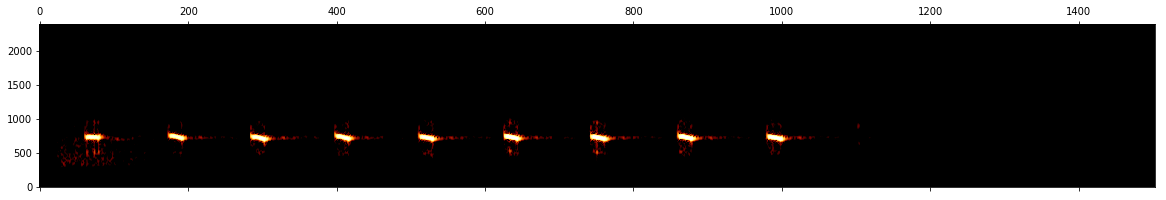

CR_575sl
14.019138321995465


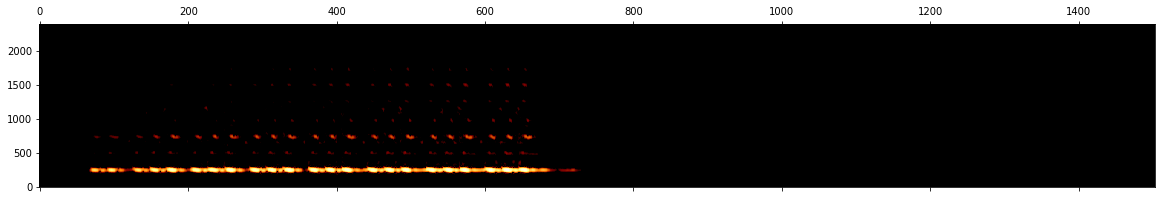

CR_623ss
6.198548752834467


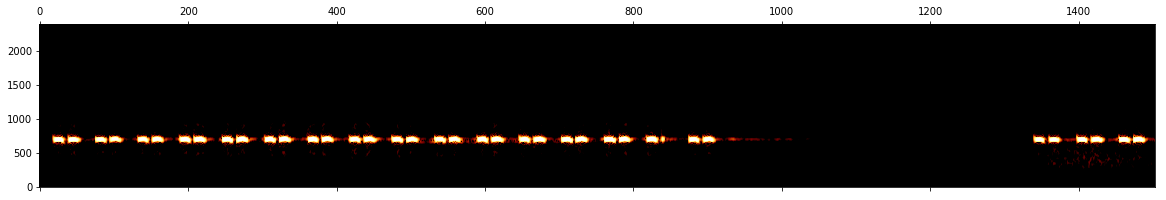

CR_487sl
19.130725623582766


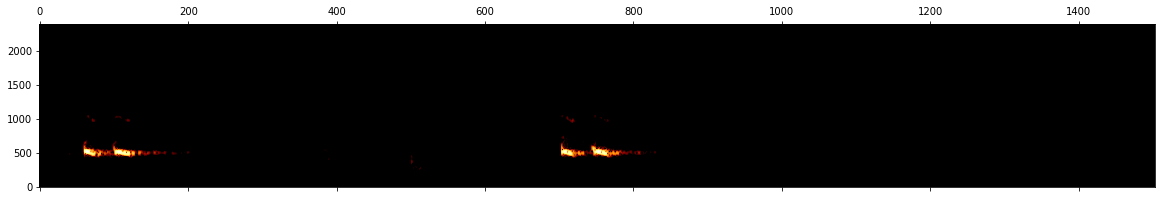

CR_475scl
9.988185941043083


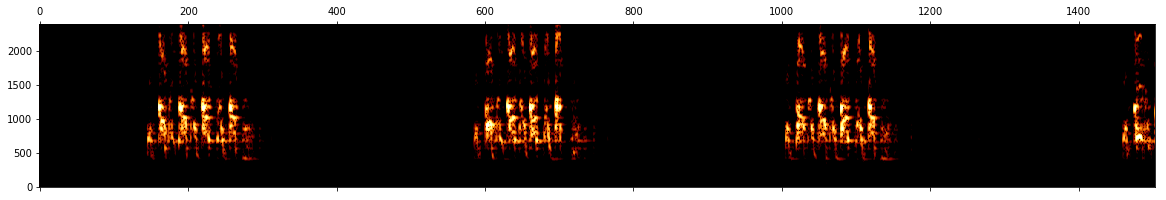

CR_470ss
5.930521541950113


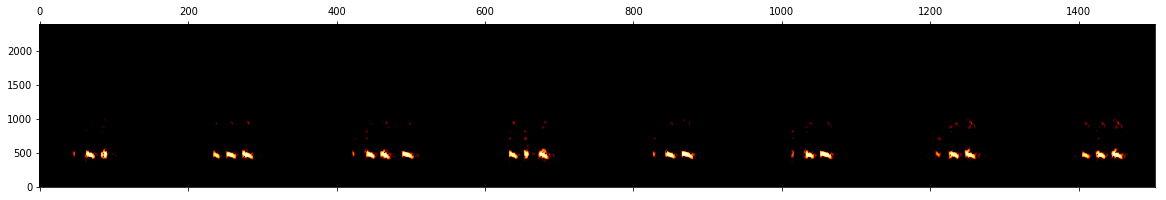

CR_619ss
6.154829931972789


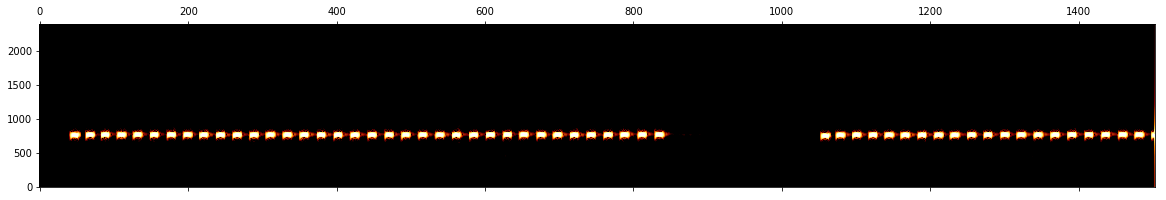

CR_615ss
6.0233106575963715


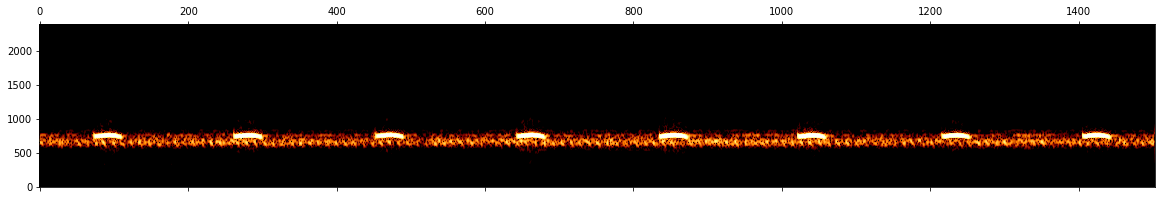

CR_tanbookame_kugirinaki
31.164081632653062


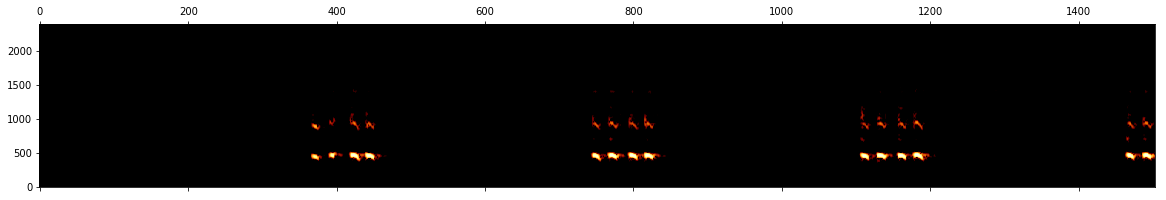

CR_481ss
5.058684807256236


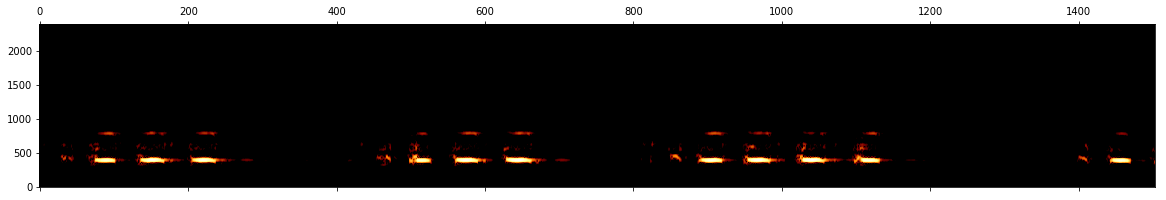

CR_582ss
5.998820861678005


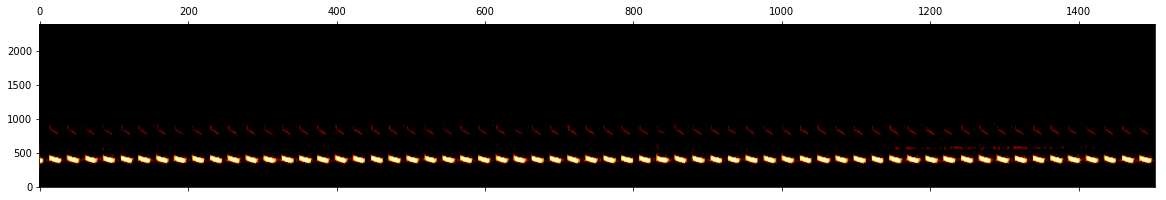

CR_hime-koorogi
21.99800453514739


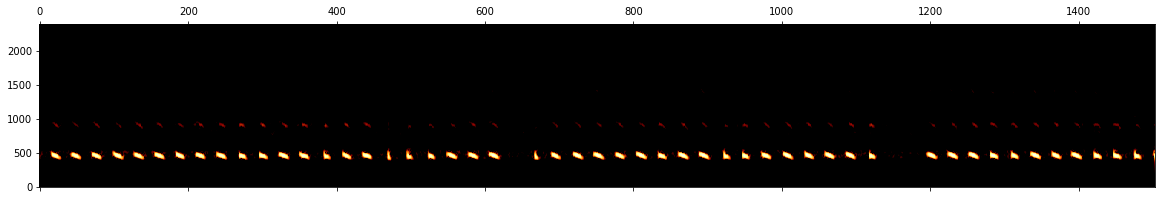

CR_641ss
6.070884353741497


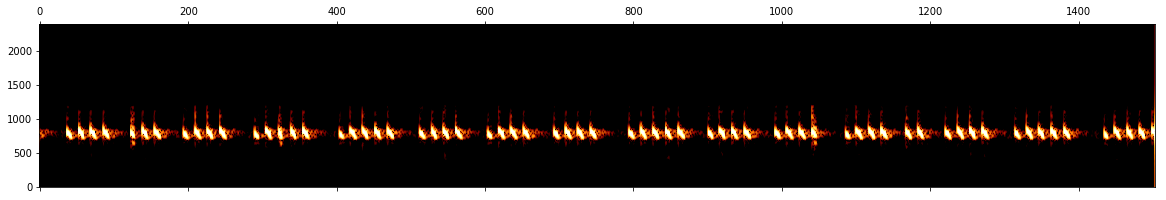

CR_482ssms
5.2851700680272105


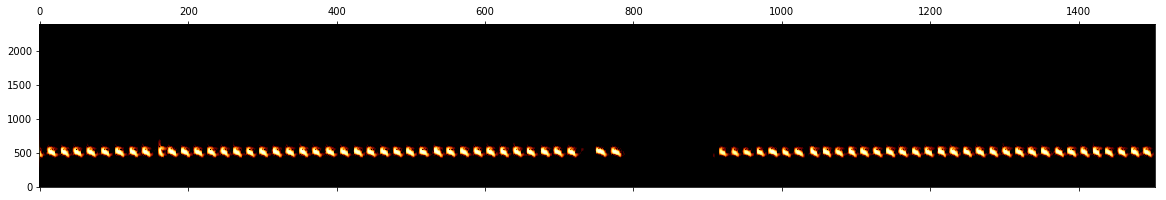

CR_594ss
6.010385487528344


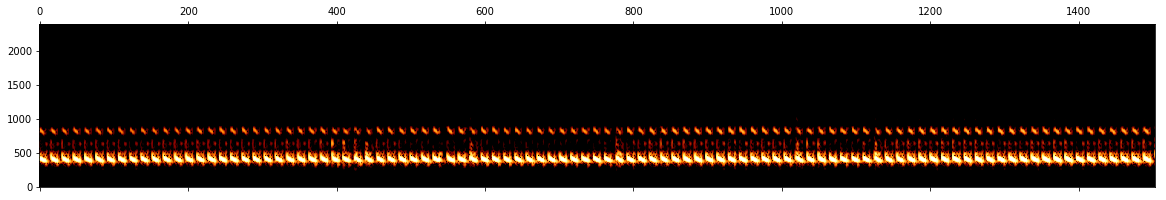

CR_622ss
6.106213151927438


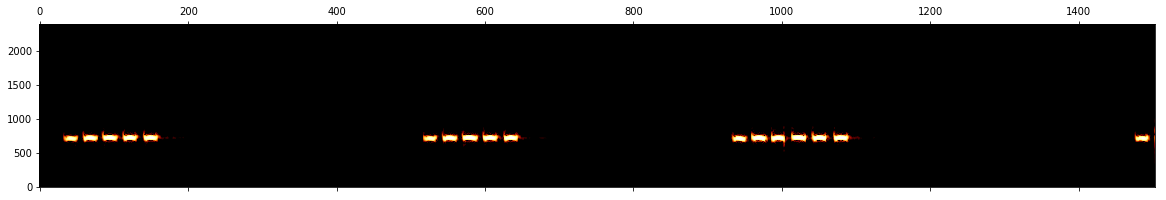

CR_mitsukado
30.34848072562358


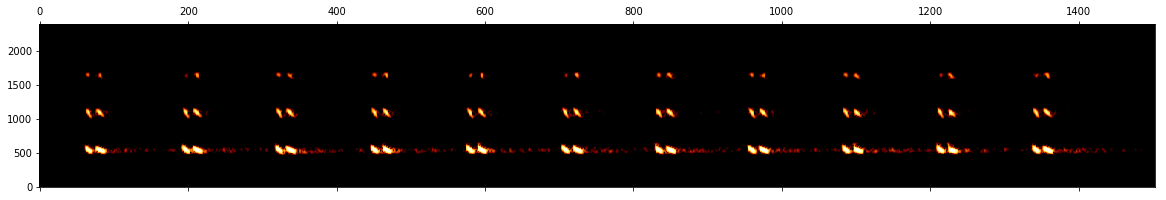

CR_462sl
12.003854875283446


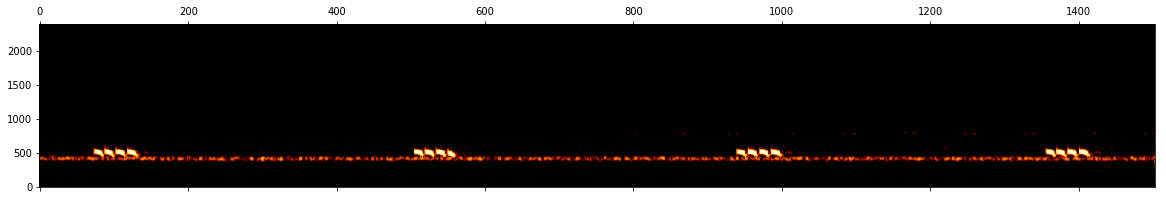

CR_452ss
5.729795918367347


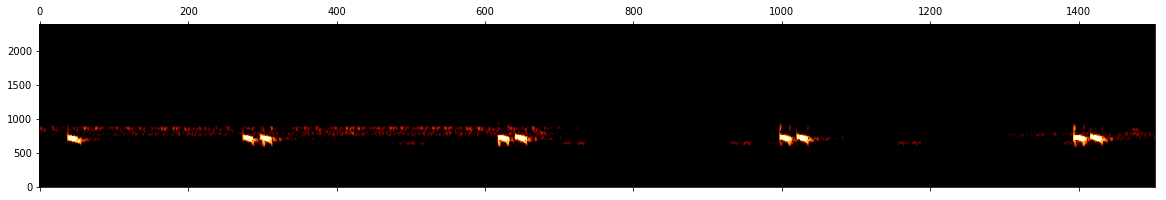

CR_551ss
5.877460317460318


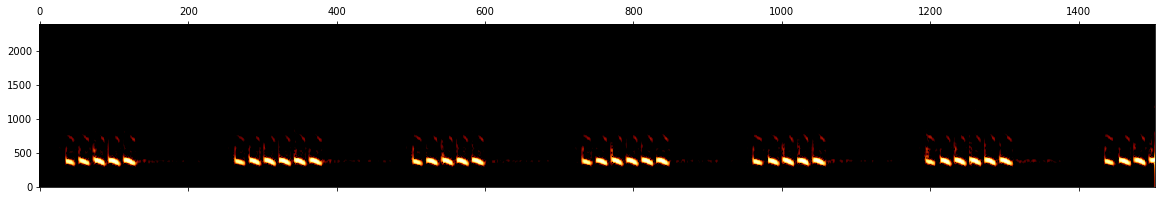

CR_581ss
6.033696145124717


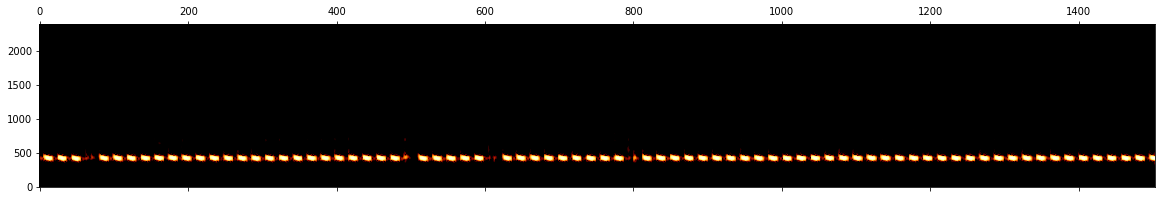

CR_684ss
5.711972789115646


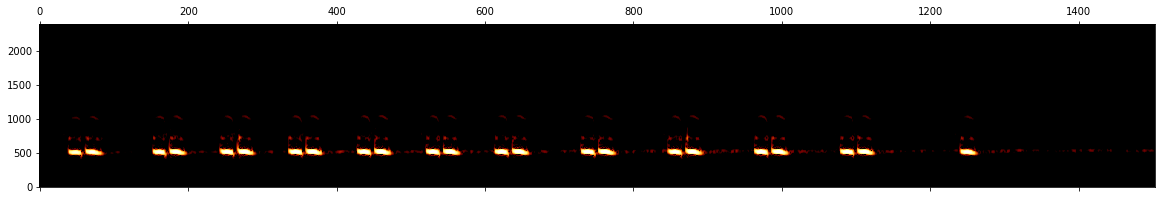

CR_679ss
5.511337868480726


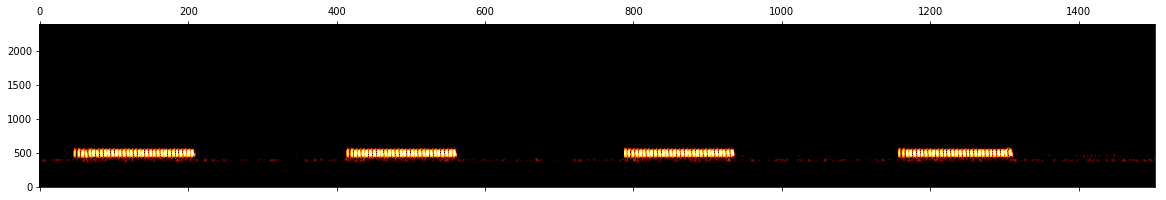

CR_616ss
6.030702947845805


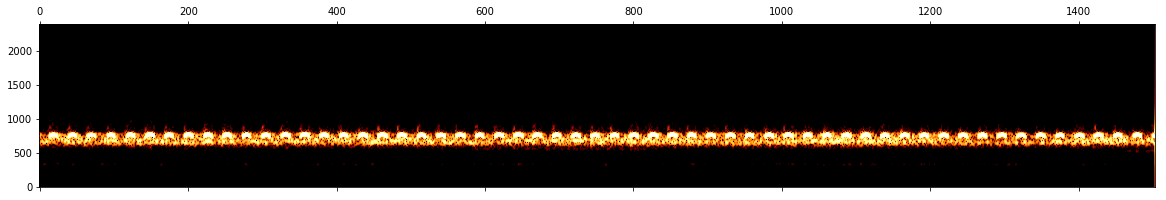

CR_taiwan-enma
37.62793650793651


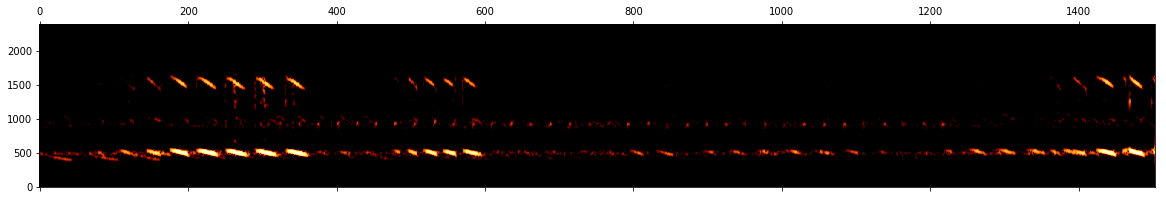

CR_577sl
11.079365079365079


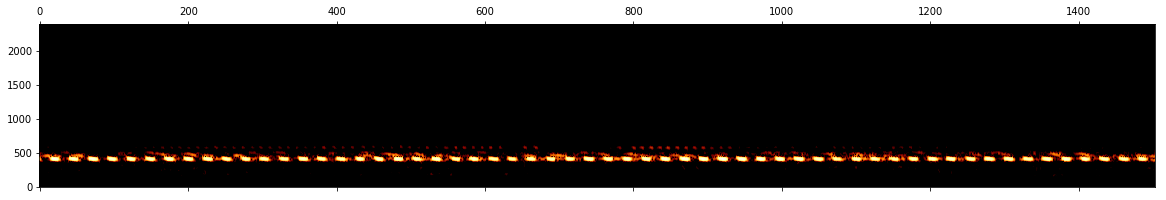

CR_621ss
5.9787301587301585


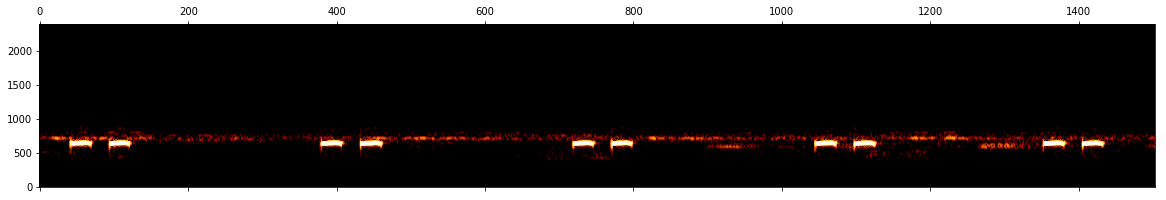

CR_kurotsuya
19.054875283446712


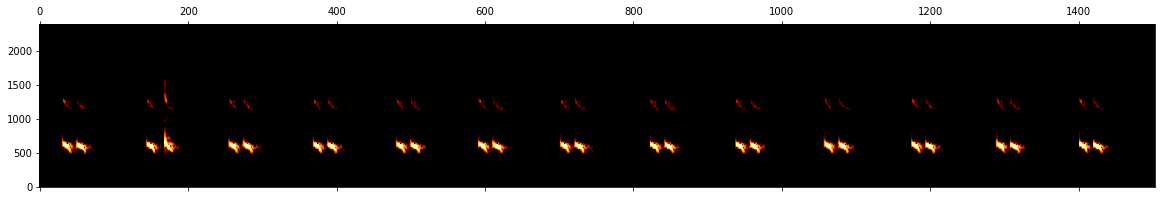

CR_465ssdw
5.144580498866213


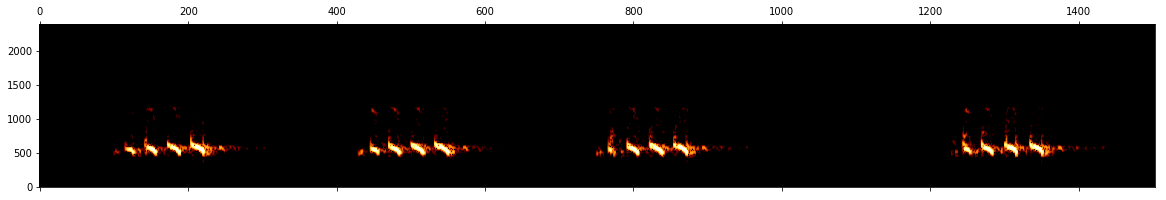

CR_453ss
5.853877551020408


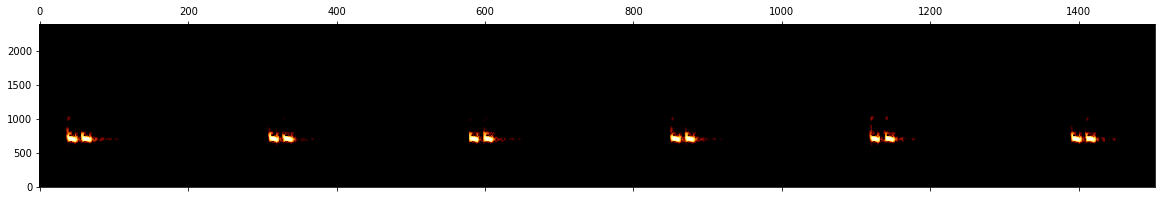

CR_480ssdw1
5.1066666666666665


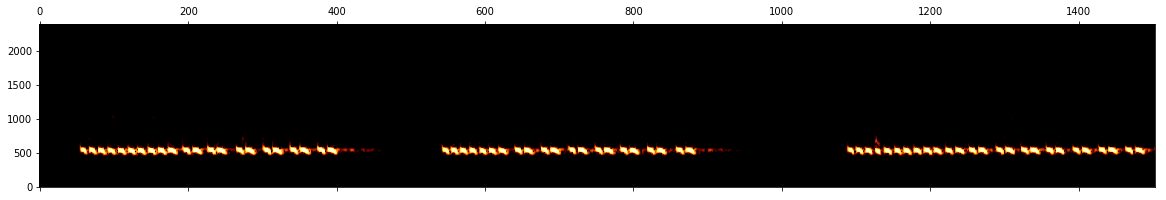

CR_483ss
5.350294784580499


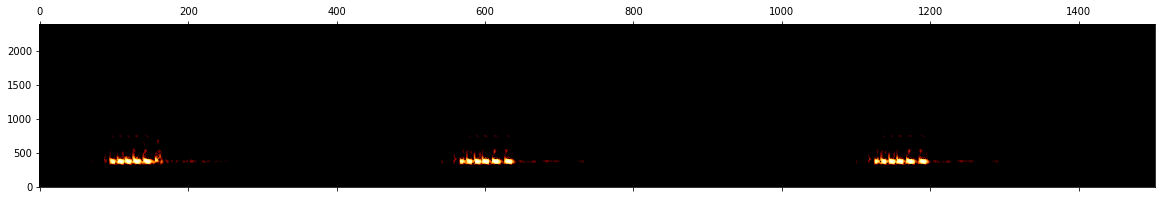

CR_585ssh
6.033560090702948


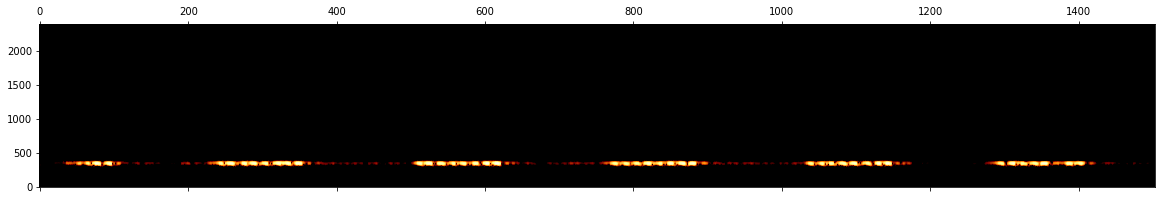

CR_585sso
5.817142857142857


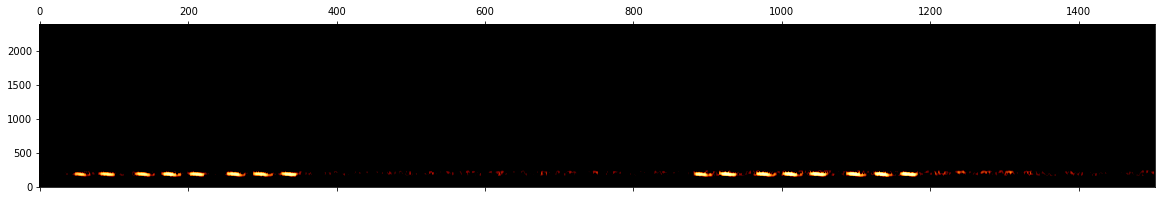

CR_kawara-suzu
17.615238095238094


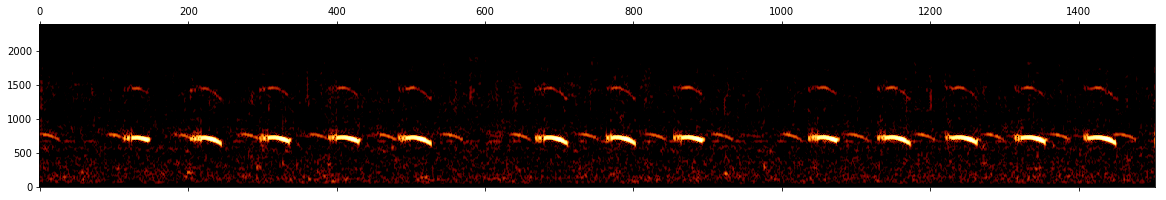

CR_ezo-enma
21.41170068027211


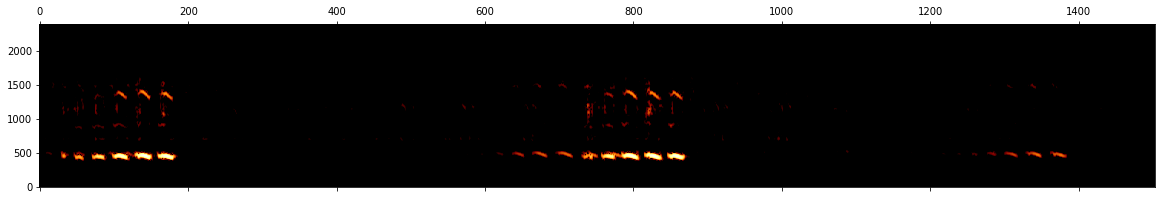

CR_685ss
6.094603174603175


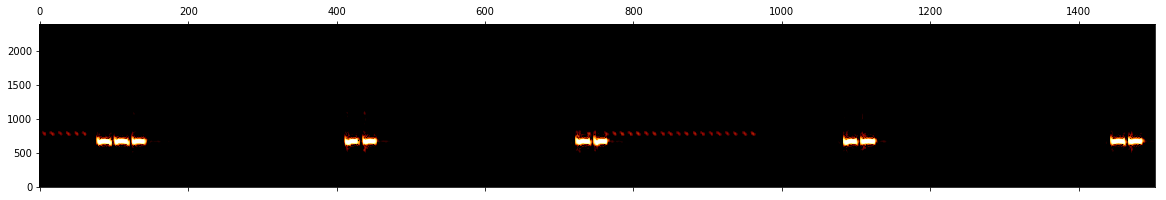

CR_617ss
6.013922902494331


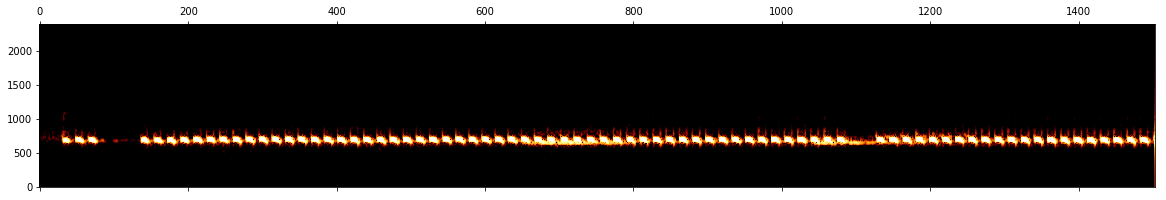

CR_591sl
8.021133786848072


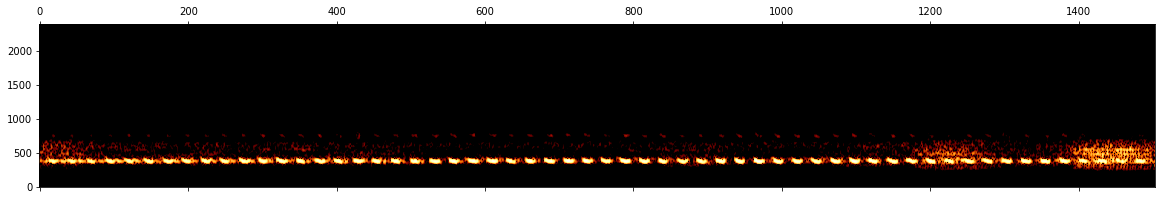

CR_ezo-suzu
13.052517006802722


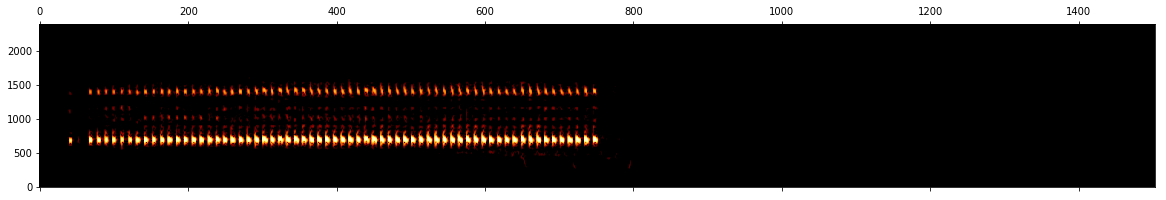

CR_601ss
6.0777777777777775


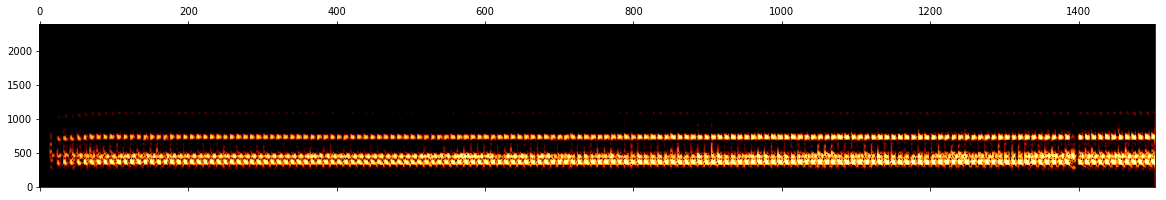

CR_snowy_tree_cricket_hot
6.033560090702948


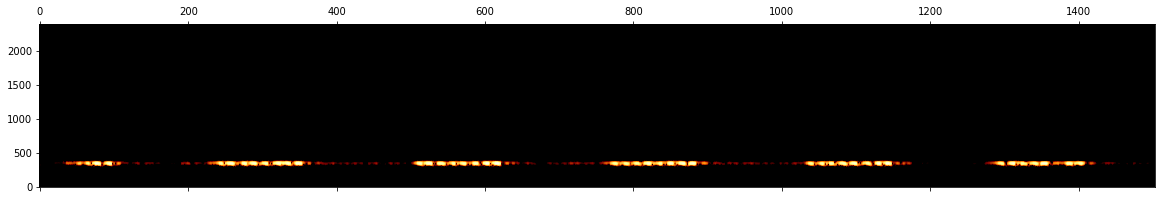

CR_437ss
7.1112471655328795


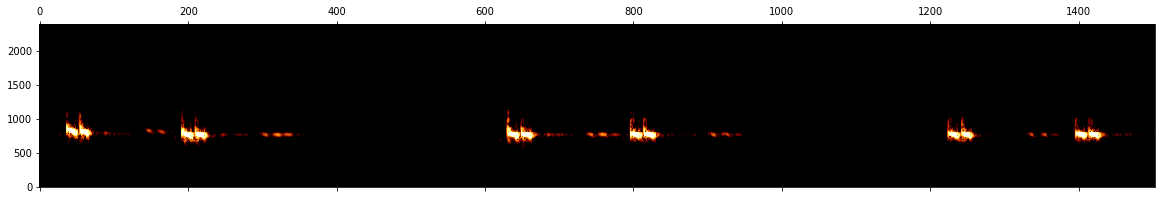

CR_682ss
5.569433106575964


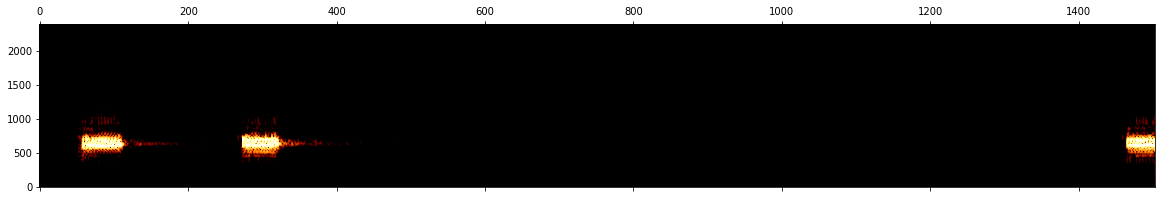

CR_610ss
6.070022675736961


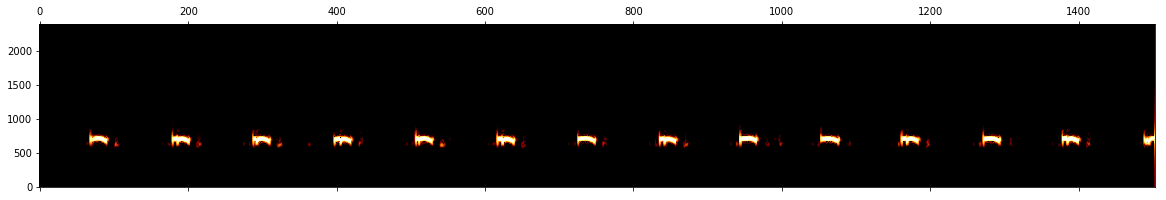

CR_484ss
5.886621315192744


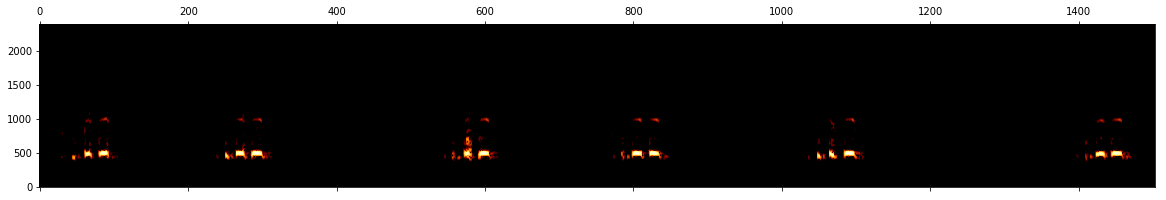

CR_479ss
5.874648526077097


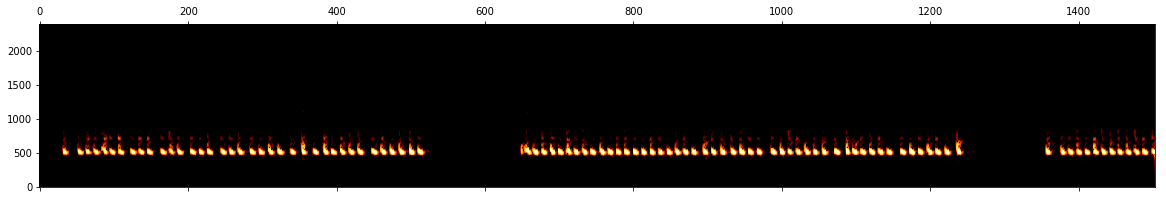

CR_480ssdw2
5.363809523809524


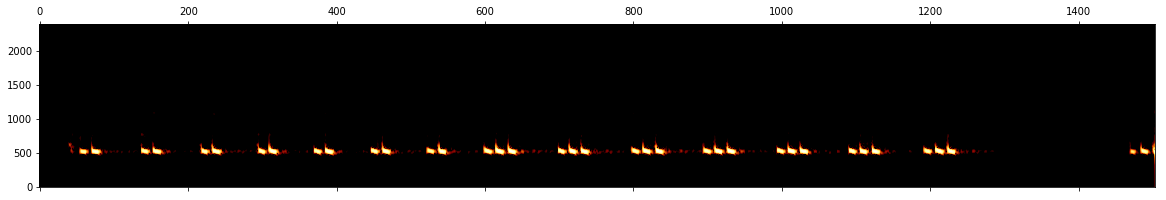

CR_587ss
6.047845804988662


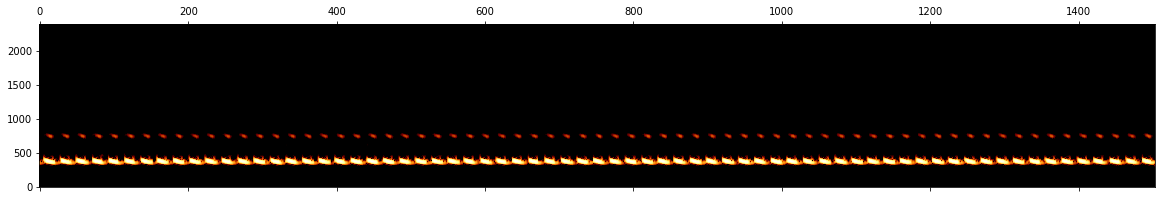

CR_488ss
5.816961451247166


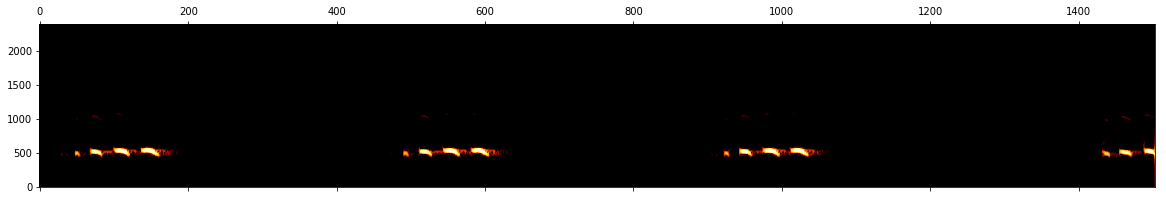

CR_499sl
18.390226757369614


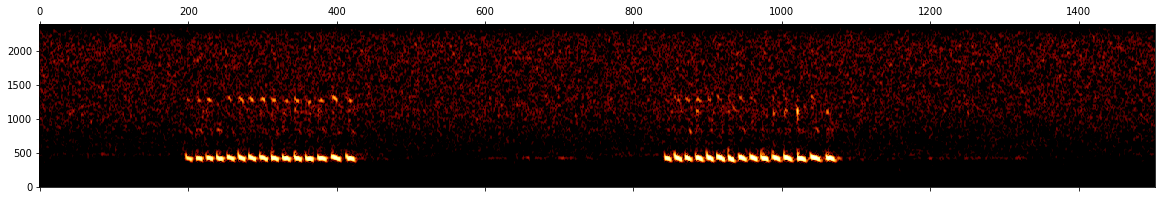

CR_454ss
7.162902494331066


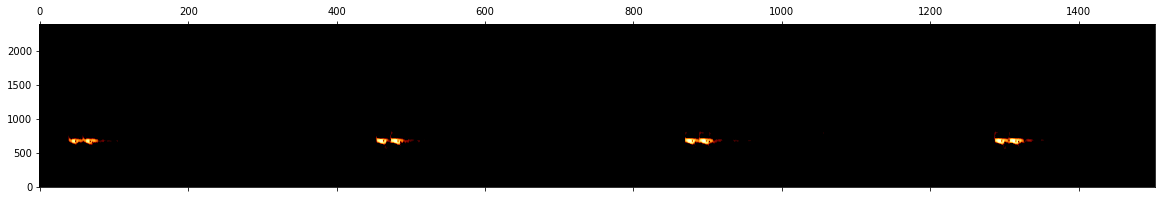

CR_492ss
5.973560090702948


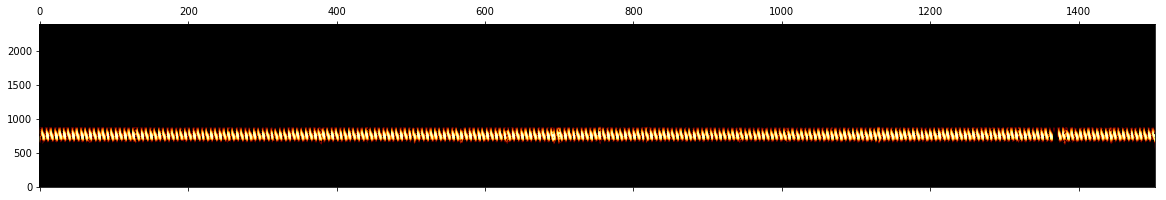

CR_kuchinaga
26.36625850340136


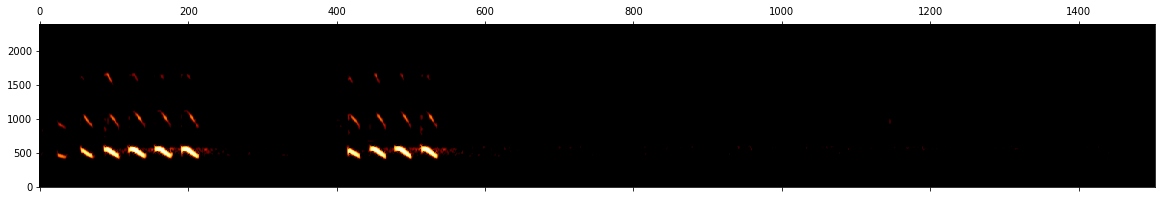

CR_enma-koorogi
21.783219954648526


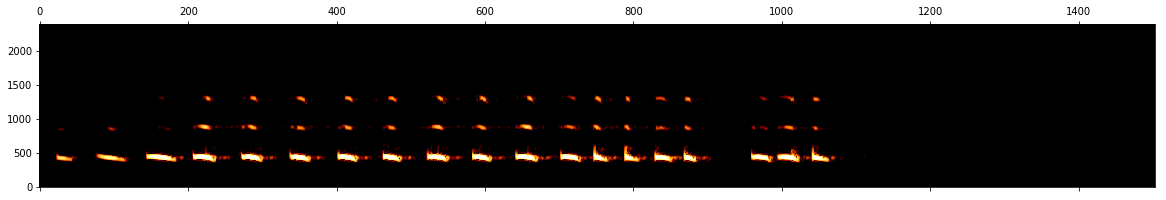

CR_442ss
5.136281179138322


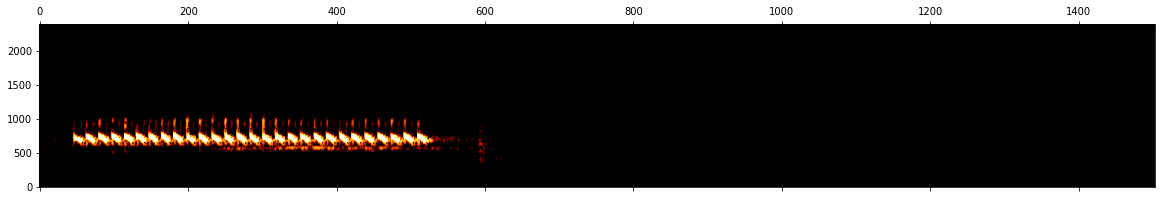

CR_snowy_tree_cricket_cold
5.822947845804989


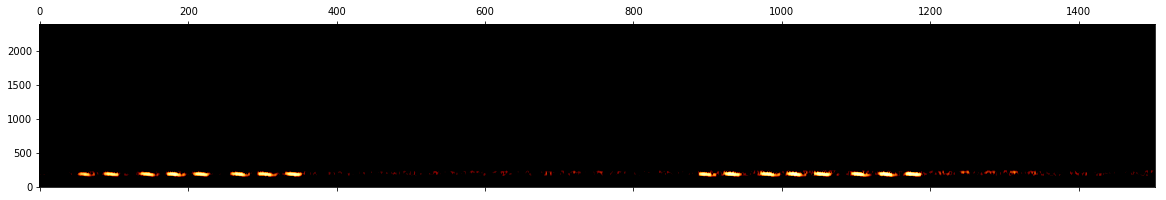

CR_kinhibari
20.45387755102041


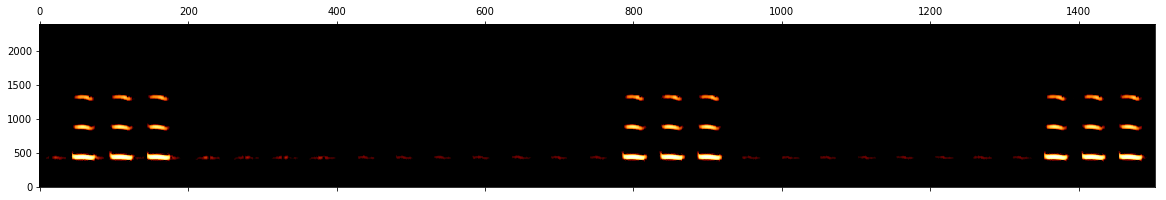

CR_kaya-hibari
14.483446712018141


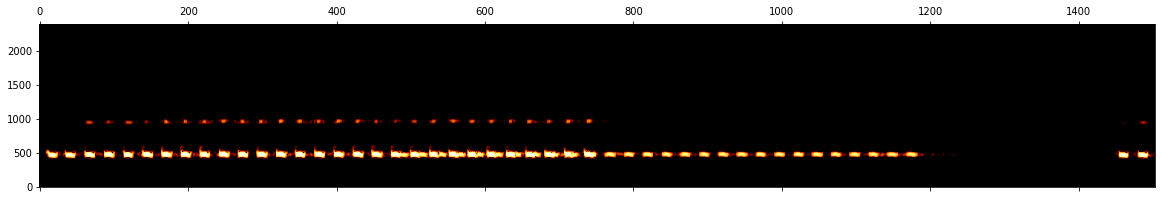

CR_treecricket
9.032607709750566


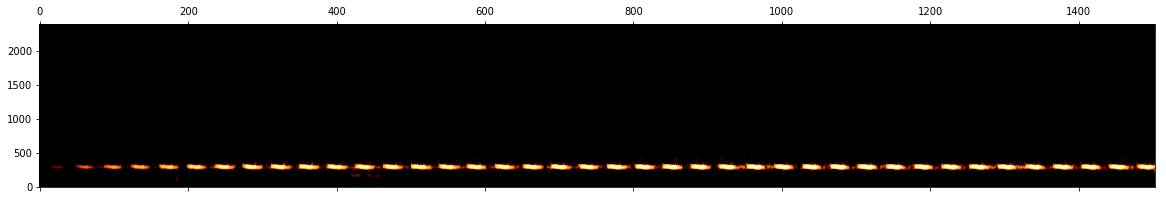

CR_491srds
5.21891156462585


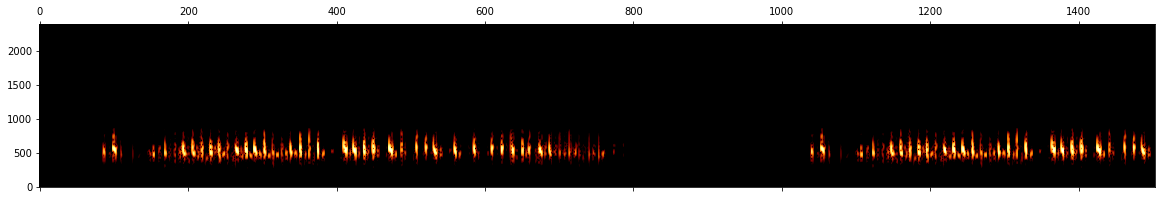

CR_683ss
8.85156462585034


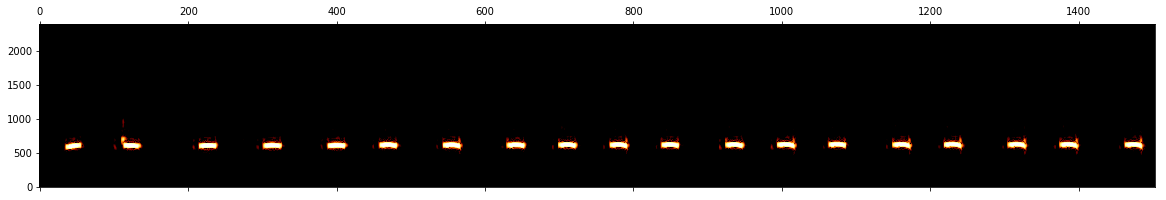

CR_611ss
6.039501133786848


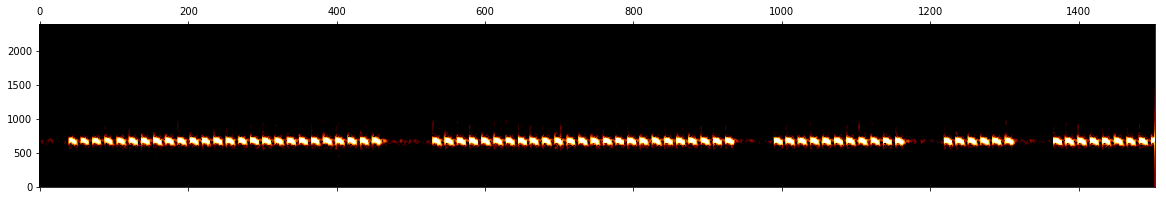

CR_630ss
5.091972789115646


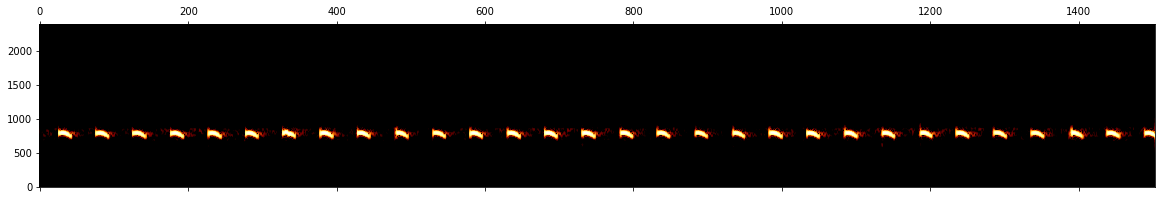

CR_586ss
6.0574149659863945


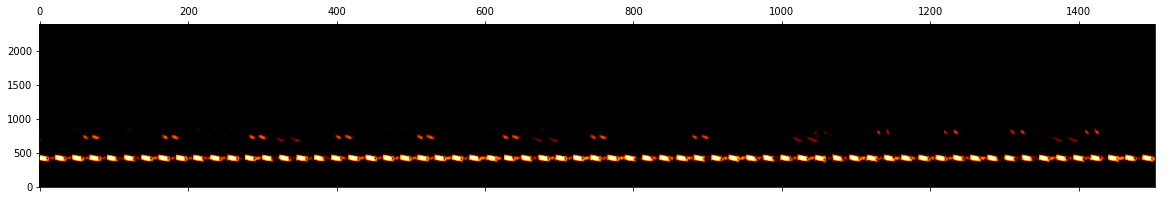

CR_489ss
5.508934240362811


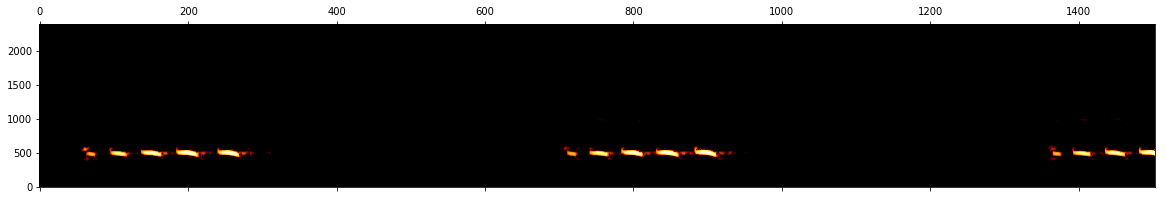

CR_shiba-suzu
18.683356009070295


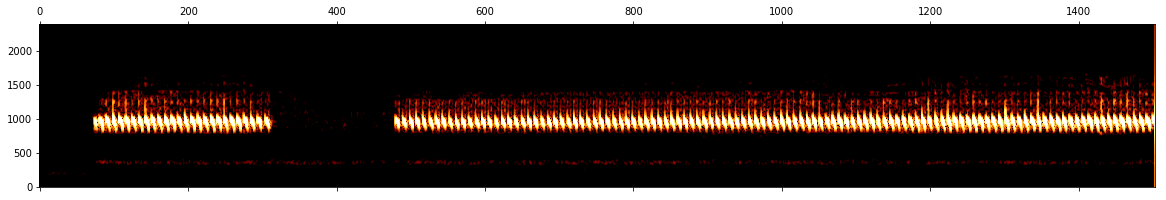

CR_467ssdw
5.155283446712018


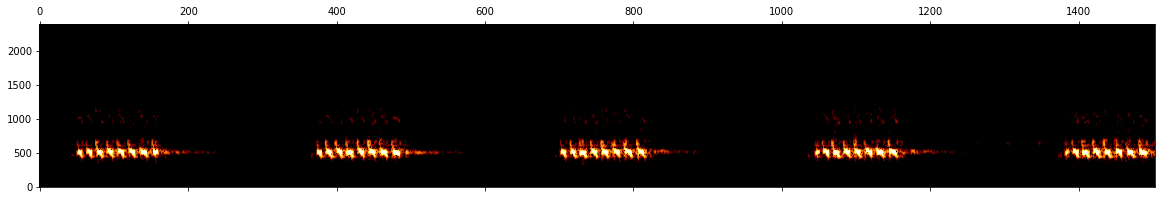

CR_482scdg
6.995011337868481


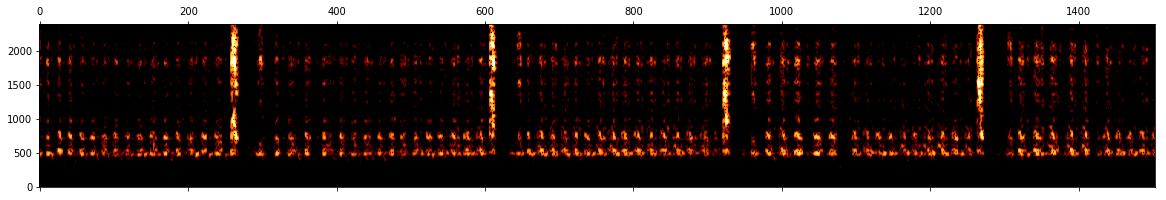

CR_tsuzuresase
24.90920634920635


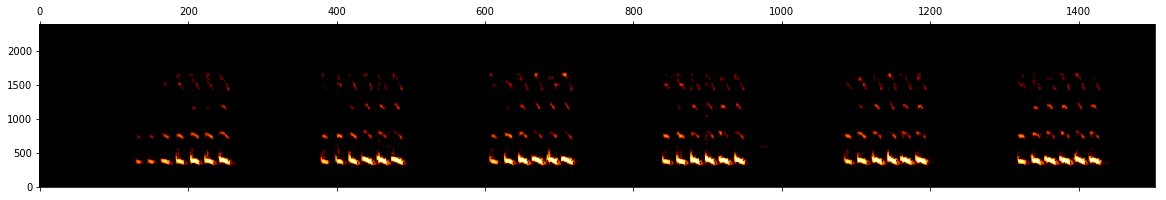

CR_tanbo-koorogi
14.59954648526077


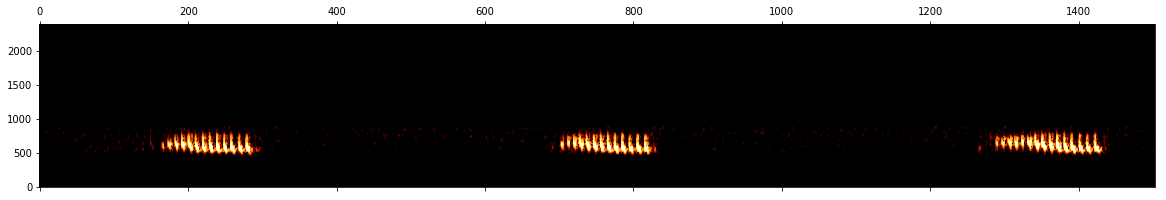

CR_haraokame
29.53578231292517


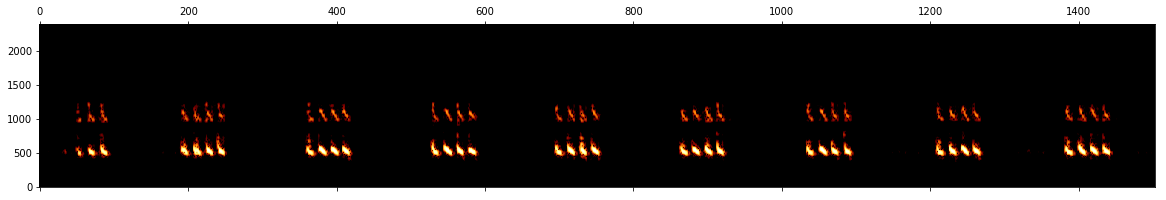

CR_521ss2
5.622721088435374


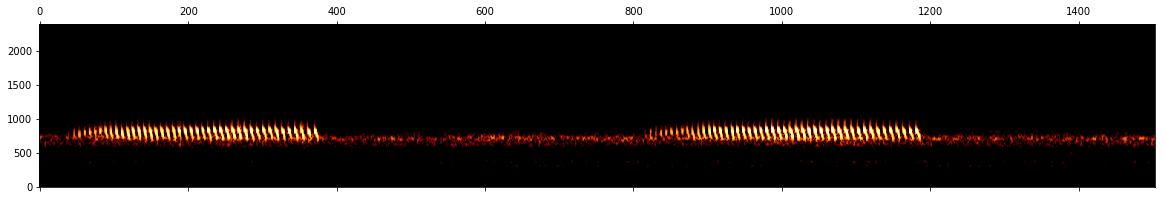

CR_672ss
6.878458049886621


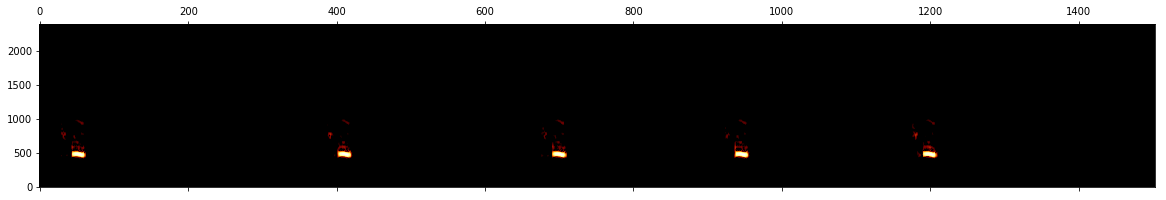

CR_590ss
5.7516553287981855


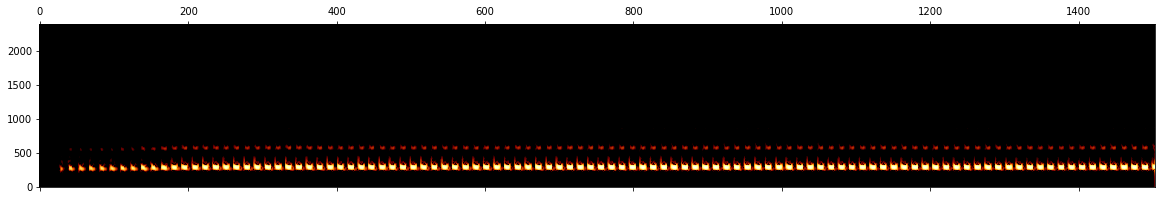

CR_black-horned_tree_cricket
6.050294784580499


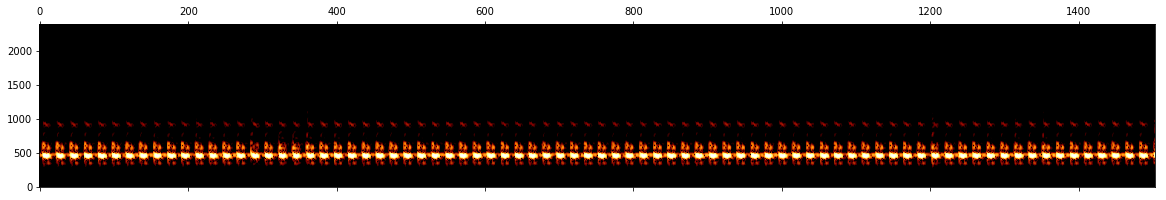

CR_hime-suzu
24.241632653061224


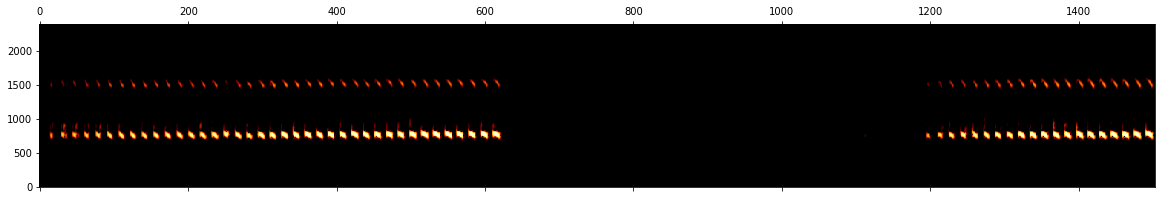

CR_443ss
12.081768707482993


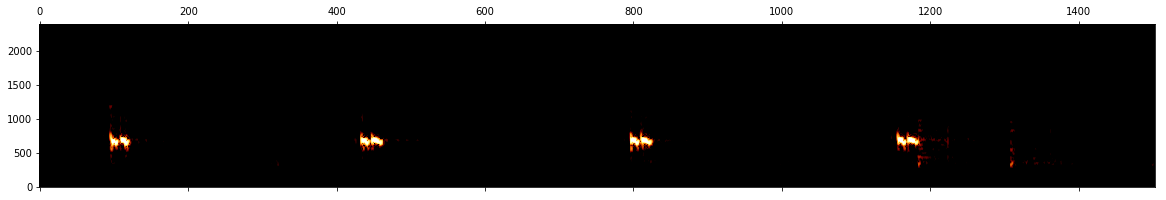

CR_fieldcricket1
7.335963718820862


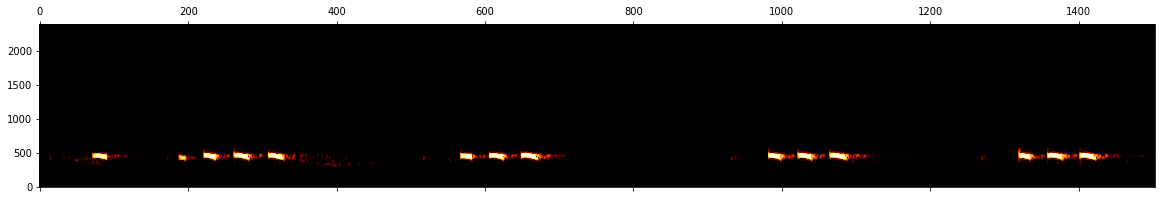

CR_585ss
5.979410430839002


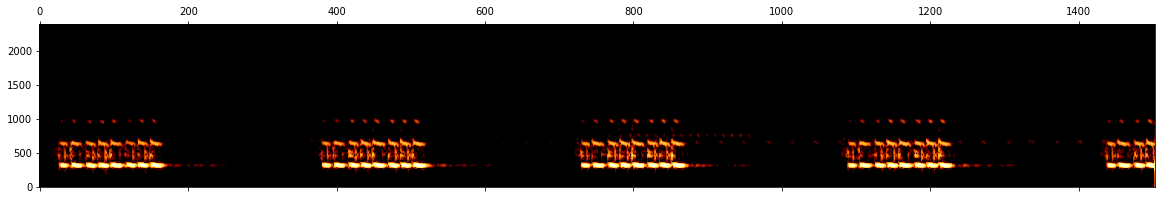

CR_612ss
5.935555555555555


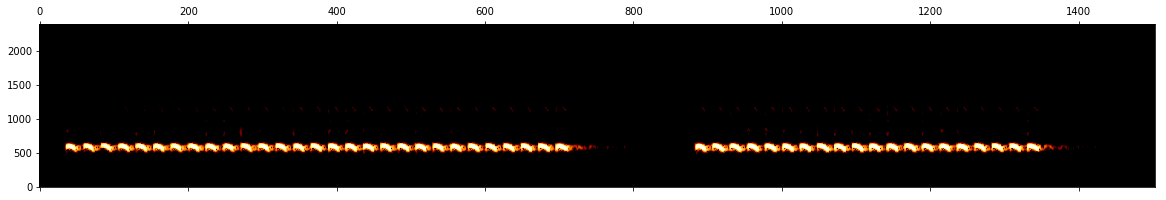

CR_671ss
5.986712018140589


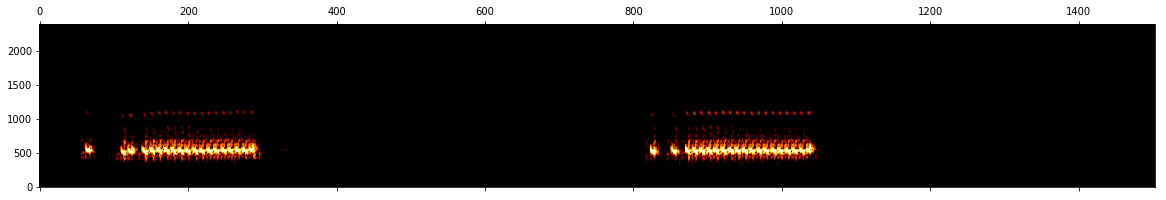

CR_house_cricket
5.25092970521542


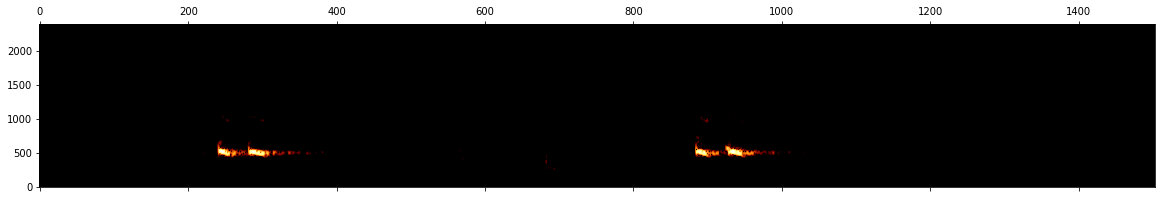

CR_589ss
6.050294784580499


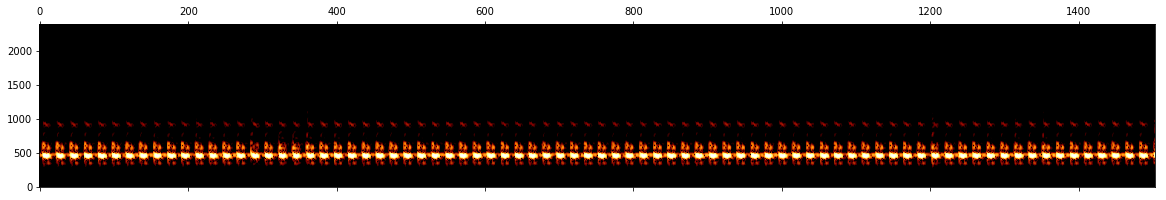

CR_moriokame2
31.187301587301587


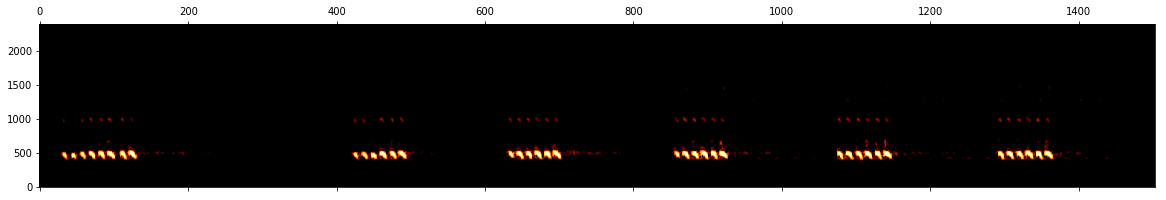

CR_oookame
27.811700680272107


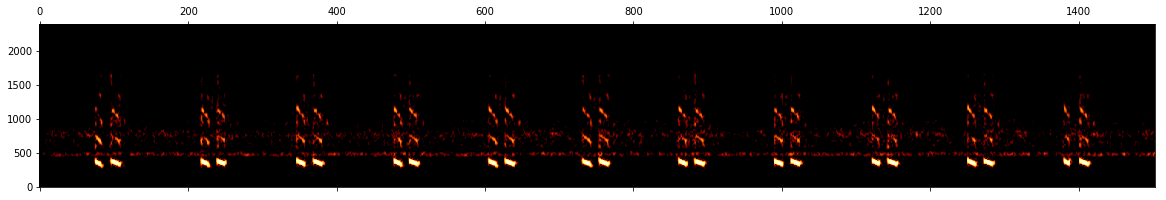

CR_466ssdw
5.127800453514739


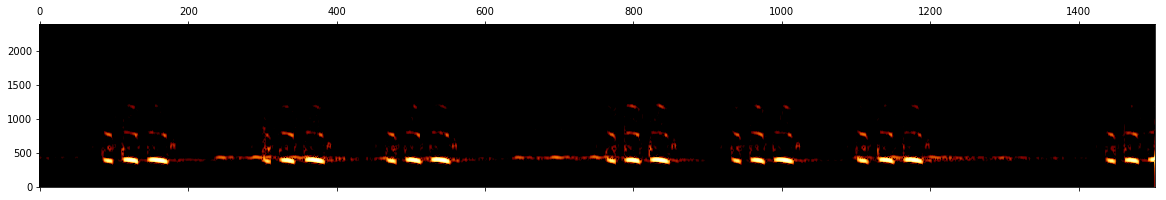

CR_585ssj
6.018956916099773


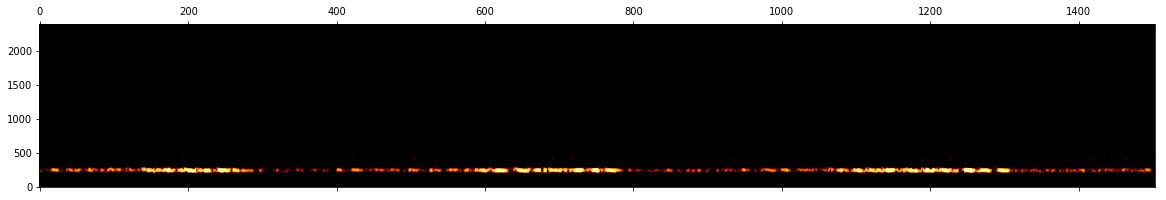

CR_madara-suzu
22.935510204081634


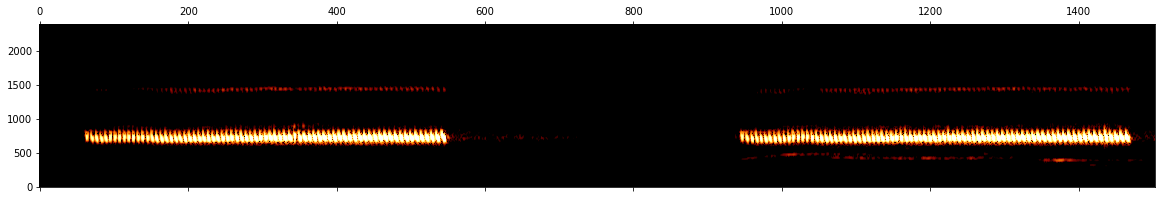

CR_hama-suzu
30.934784580498867


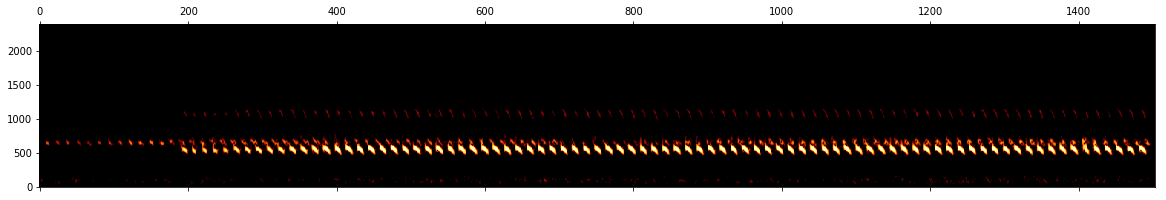

CR_northern_mole_cricket
6.108117913832199


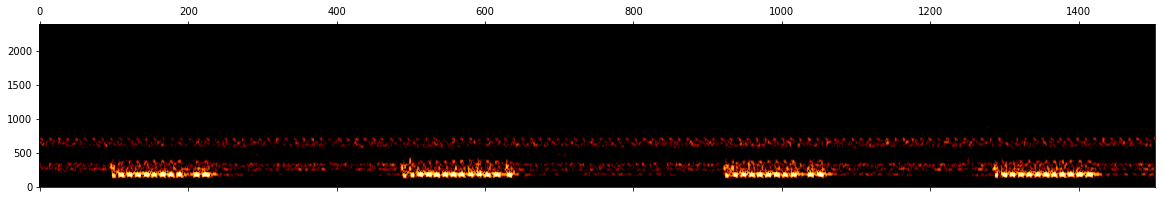

CR_593ss
5.995011337868481


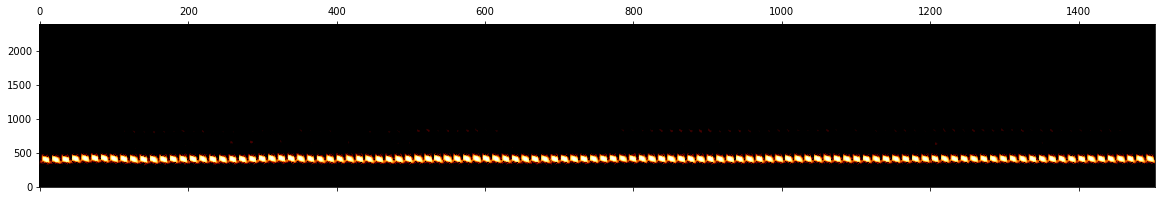

CR_501ss
5.875147392290249


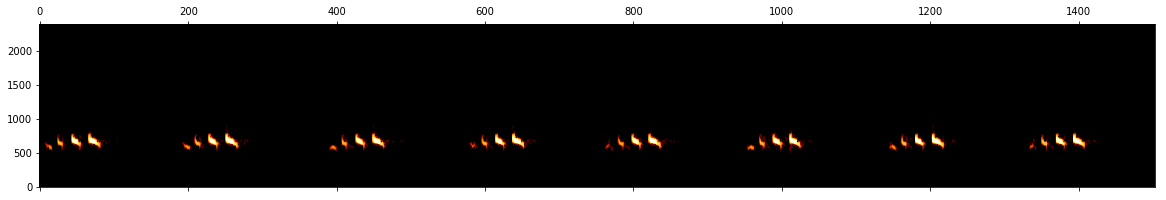

CR_kuma-koorogi
26.534603174603173


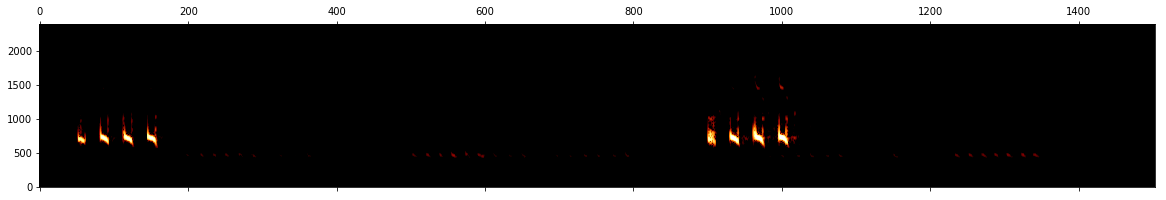

CR_475sct
10.003129251700681


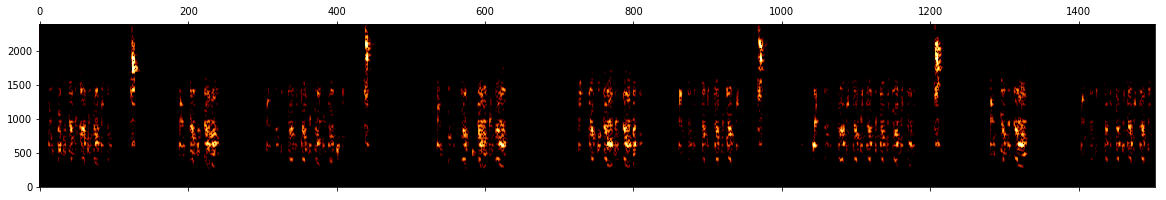

CR_440ss
5.092108843537415


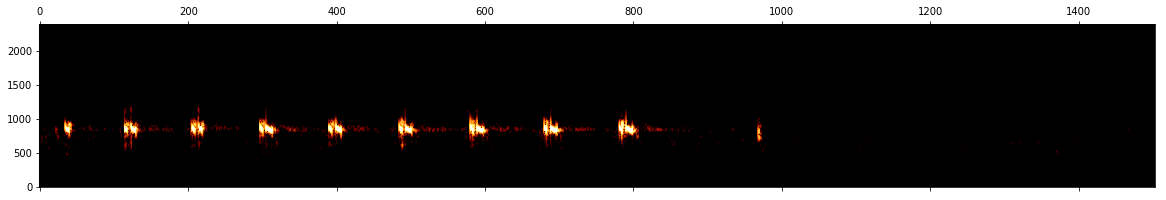

CR_632ss
5.10875283446712


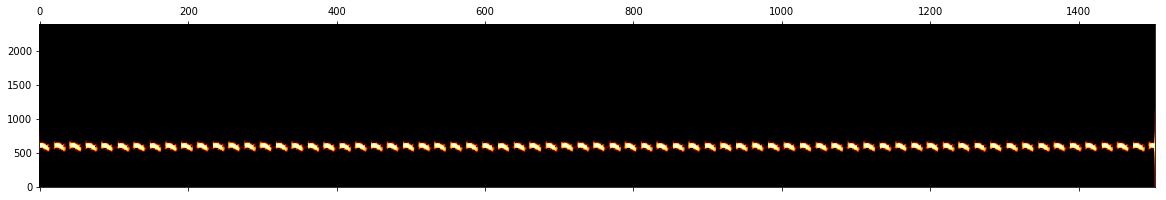

CR_613ss
5.862857142857143


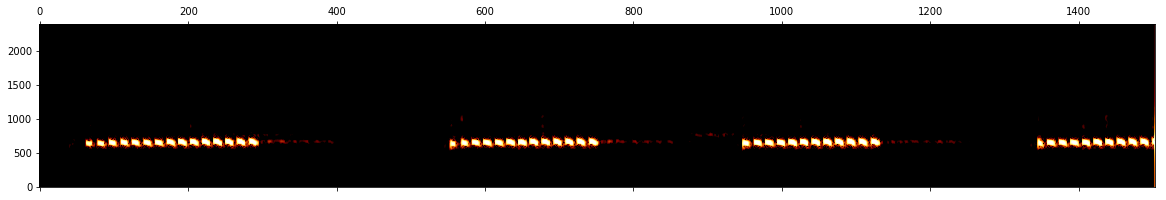

CR_681ss
5.154331065759637


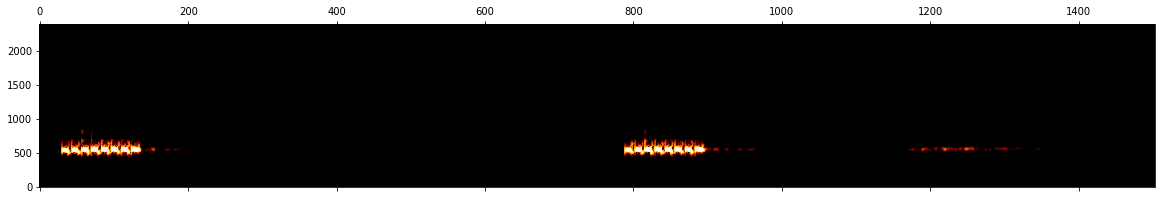

CR_kamado
33.332244897959185


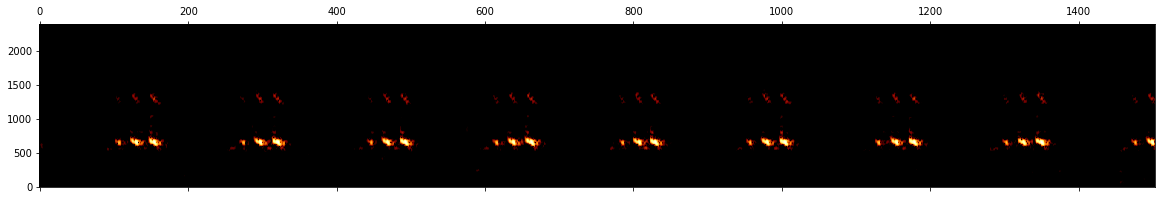

CR_spring_field_cricket
5.9098412698412695


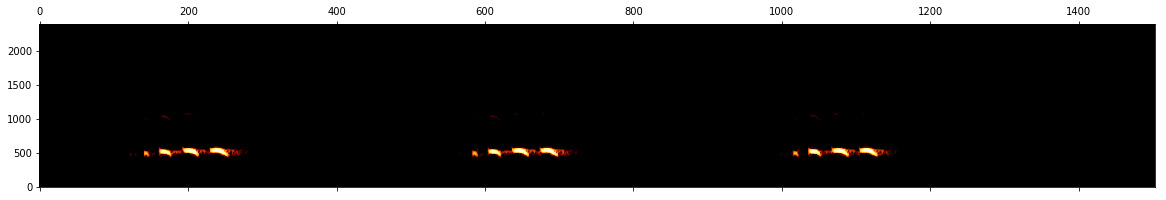

CR_438ss
6.093832199546485


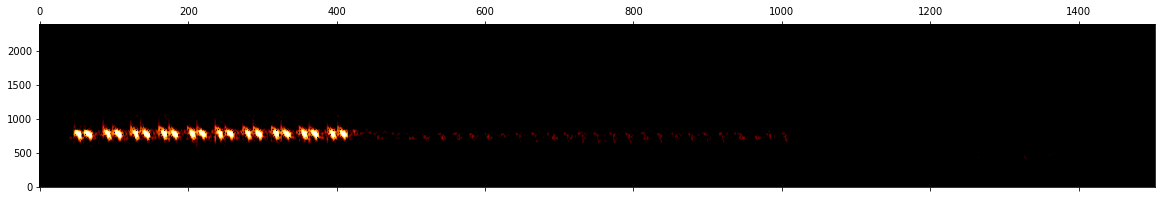

CR_588ss
5.963809523809524


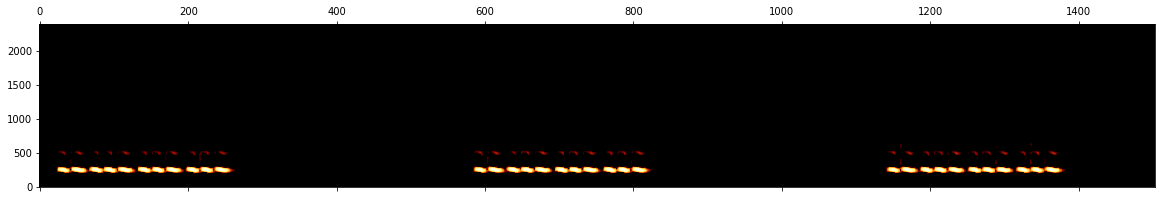

CR_521ss
5.804988662131519


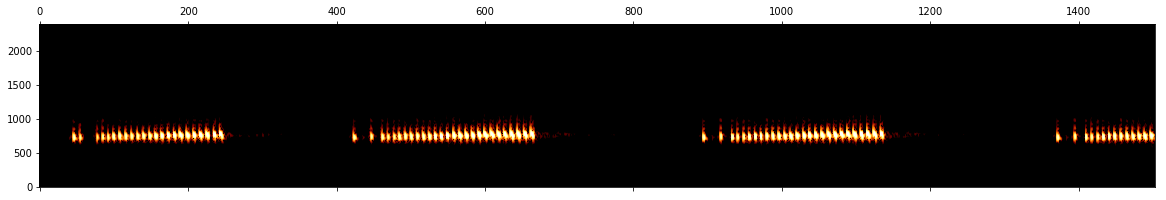

CR_kogata-koorogi
21.70482993197279


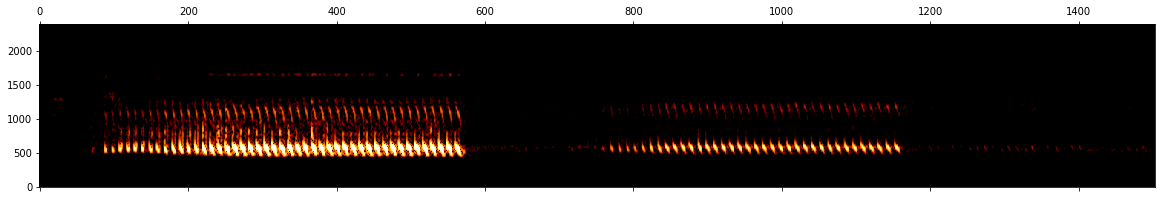

CR_592ss
5.931927437641724


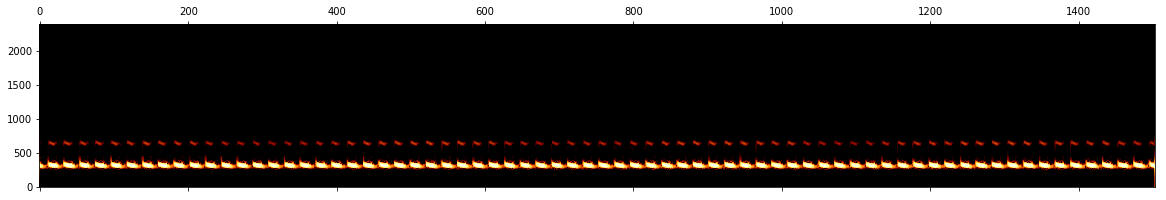

CR_624ss
5.934149659863945


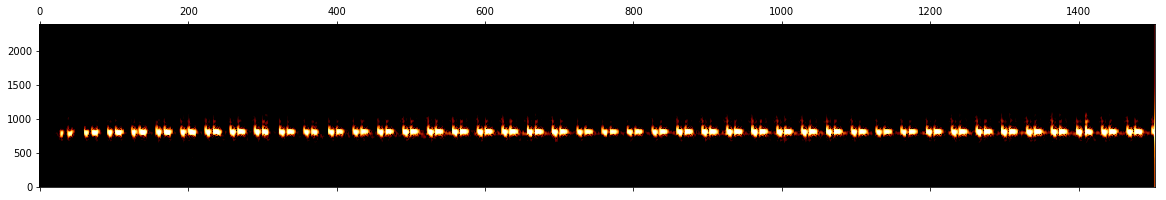

CR_464sldw
14.721451247165533


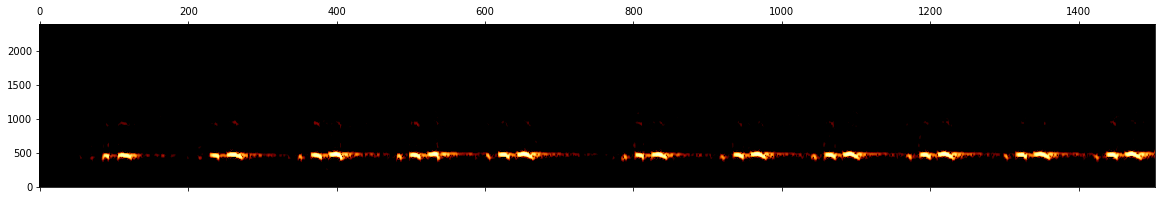

CR_491ss
6.003809523809524


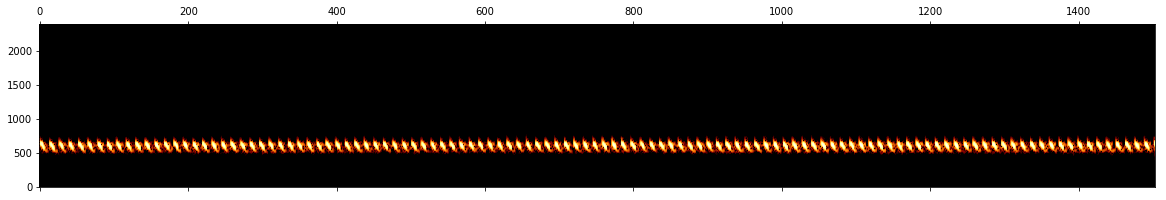

CR_441ss
5.41092970521542


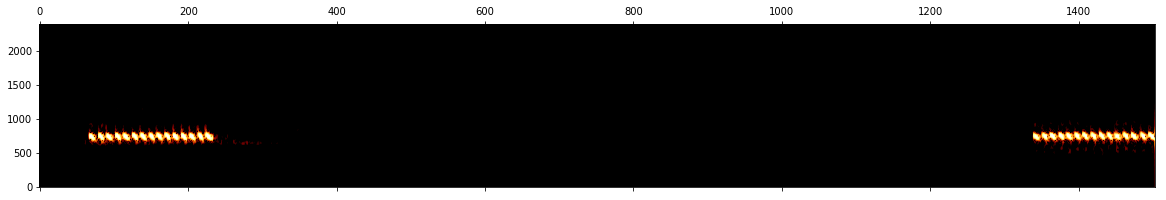

CR_kusahibari
32.905578231292516


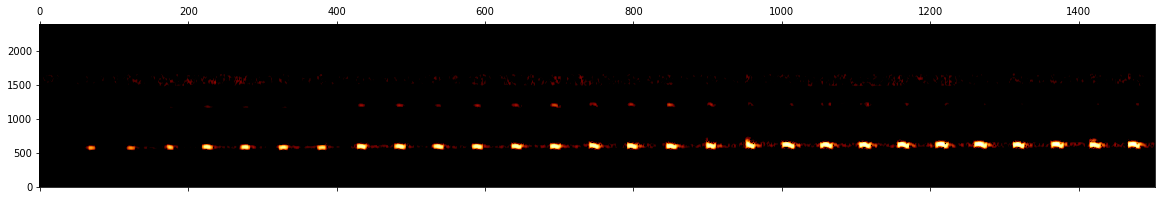

CR_yamato-hibari
18.2421768707483


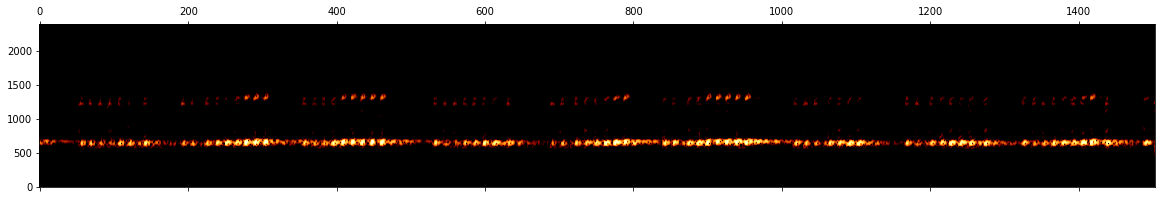

In [27]:
for idx, row in tqdm(wav_df.iterrows()):
    if row.wavloc.stem.split('_')[0] != 'CR': continue
    print(row.wavloc.stem)
    data, rate = librosa.core.load(
                path=row.wavloc,
                sr=None,
                duration = 1.5,
                mono=True
            )
    print(librosa.core.get_duration(filename = row.wavloc))
    audio = butter_bandpass_filter(data, lowcut = 500, highcut=int(rate/2)-2, fs=rate, order=4)
    spectrogram = sg.spectrogram(audio, rate , hparams)
    fig, ax = plt.subplots(figsize=(20,3))
    ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
    plt.show()